## Requirements

Download and install the latest versions of catalyst and other libraries required for this tutorial.

In [1]:
!ls

sample_data


In [2]:
!python -m pip install pytorch_lightning -qqq

     |████████████████████████████████| 696kB 7.9MB/s 
     |████████████████████████████████| 276kB 16.7MB/s 
     |████████████████████████████████| 829kB 23.0MB/s 
     |████████████████████████████████| 102kB 9.3MB/s 
     |████████████████████████████████| 1.3MB 23.2MB/s 
     |████████████████████████████████| 143kB 57.0MB/s 
     |████████████████████████████████| 296kB 53.3MB/s 


# Download dataset to colab

In [3]:
!ls

sample_data


In [4]:
import requests
from zipfile import ZipFile
from pathlib import Path

class google_drive_downloader():
    # credit: converted to class from https://stackoverflow.com/a/39225039

    def __init__(self, cwd_path=None, data_path=None):
        """
        data_path: root directory of where to extract data
        """

        if cwd_path is None:
            # By default, we will assume '.' data
            self.cwd_path = Path('.').absolute()
        else:
            self.cwd_path = cwd_path.absolute()

        if data_path is None:
            # By default, we will assume ./data
            self.data_path = self.cwd_path / 'data'
        else:
            self.data_path = data_path.absolute()

        if not self.data_path.exists():
            self.data_path.mkdir()

        self.zip_fname = self.cwd_path / 'tmp_download_from_gdrive.zip'

    def get_confirm_token(self, response):
        for key, value in response.cookies.items():
            if key.startswith('download_warning'):
                return value

        return None

    def save_response_content(self, response):
        CHUNK_SIZE = 32768

        with open(self.zip_fname, "wb") as f:
            for chunk in response.iter_content(CHUNK_SIZE):
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)

    def download_as_zip(self, gdrive_id):
        URL = "https://docs.google.com/uc?export=download"

        session = requests.Session()

        response = session.get(URL, params = { 'id' : gdrive_id }, stream = True)
        token = self.get_confirm_token(response)

        if token:
            params = { 'id' : gdrive_id, 'confirm' : token }
            response = session.get(URL, params = params, stream = True)

        self.save_response_content(response)    


    def unzip_to_data_path(self):
        """Extract data to data path"""
        with ZipFile(self.zip_fname, 'r') as zf:
            zf.extractall(path=self.data_path)

    def remove_archive_subfolder(self, archive_subfolder):
        """
        Move: /data_path/unwanted_folder/train -> /data_path/train
        """
        # Create path with unwanted_folder
        move_up_path = self.data_path / archive_subfolder

        # Move all directories
        for folder in move_up_path.iterdir():
            if folder.is_dir():
                new_folder = folder.parent.parent / folder.name
                folder.rename(new_folder)


        # Delete the unwanted_folder directory
        move_up_path.rmdir()

    def print_data_path_contents(self):
        print(f"data_path:{self.data_path}")
        print("directory list:")
        # print data_path contents
        for folder in self.data_path.iterdir():
            print(folder)

    def import_gdrive_dataset(self, gdrive_id, archive_subfolder=None):
        """
           1. downloads the data from the specified gdrive_id as a zip 
           2. extracts the downloaded data to the specified data_path
           3. deletes the temporary zip file
        """
        self.download_as_zip(gdrive_id)
        self.unzip_to_data_path()

        # Delete the temporary file (using Path)
        self.zip_fname.unlink()

        if archive_subfolder is not None:
            self.remove_archive_subfolder(archive_subfolder)

        # Display result
        self.print_data_path_contents()



In [5]:
!ls
gdd = google_drive_downloader()
gdd.import_gdrive_dataset(gdrive_id='1iYaNijLmzsrMlAdMoUEhhJuo-5bkeAuj', archive_subfolder='segmentation_data')

sample_data
data_path:/content/data
directory list:
/content/data/train_masks
/content/data/test
/content/data/train


In [6]:
from pathlib import Path
import random

class pathlib_utils():
    """
    paths: place to keep track of all paths used within this project
            : CWD is the root path for the current working directory
            : DATA is the root path for all data (may or may not be inside CWD)

    dir_type: ['images','dirs'] :: Indicates whether this folder contains subdirectories, or images

    """

    def __init__(self, DATA='.', CWD='.'):

        # Pathlib Path(), for each key
        self.paths = {'ROOT': Path('/'),
                      'DATA': Path(DATA), 
                      'CWD': Path(DATA) }

        # Full Path(), for each key
        self.path_lists = {'DATA': self.get_path_lists('DATA'), 
                           'CWD': self.get_path_lists('CWD') }

        # Same as path_lists but only file/dir names, for each key
        init_data_names, _ = self.get_name_lists('DATA')
        init_cwd_names, _ = self.get_name_lists('CWD')
        self.name_lists = {'DATA': init_data_names, 
                           'CWD': init_cwd_names }

        # Length of each self.path_lists, for each key
        self.len = {'DATA': len(self.path_lists['DATA']), 
                   'CWD': len(self.path_lists['DATA']) }

        # Flag to indicate whether each list in self.path_lists is image or subdirectories, for each key
        self.dir_type = {'ROOT': 'dirs',
                         'DATA': 'dirs',
                         'CWD': 'dirs' }

 
    def add(self, new_paths, ROOT='ROOT'):

        assert ROOT in self.paths.keys()
        for key, value in new_paths.items():
            # Append value to path
            self.paths[key] = self.paths[ROOT] / value
            self.path_lists[key] = self.get_path_lists(key)
            self.name_lists[key], self.dir_type[key] = self.get_name_lists(key)
            self.len[key] = len(self.path_lists[key])

    def get_path_lists(self, PATH_KEY):

        image_files = sorted([x for x in self.paths[PATH_KEY].glob("*.jpg")]+[x for x in self.paths[PATH_KEY].glob("*.gif")])
        # If list is empty, then provide a list sub directories
        if not image_files:
            dirs = [x for x in self.paths[PATH_KEY].iterdir() if x.is_dir()]
            return dirs, 'dirs'
        else:
            return image_files

    def get_name_lists(self, PATH_KEY):

        image_files = sorted([x.name for x in self.paths[PATH_KEY].glob("*.jpg")]+[x.name for x in self.paths[PATH_KEY].glob("*.gif")])
        # If list is empty, then provide a list sub directories
        if not image_files:
            dirs = [x.name for x in self.paths[PATH_KEY].iterdir() if x.is_dir()]
            return dirs, 'dirs'
        else:
            return image_files, 'images'



    def get_image(self, PATH_KEY, image_idx):
        if self.dir_type[PATH_KEY] != 'images':
            print("The directory {PATH_KEY1} has no images")
            return None

        return self.path_lists[PATH_KEY][image_idx]


    def get_image_pairs(self, PATH_KEY1, PATH_KEY2, image_idx):
        # Sometimes we would like to get a pair of corresponding images/files
        # E.g., an image and its corresponding mask
        # This function provides an assert option to ensure the filenames match
        # e.g., f1.abc f2.xyz = f1something.xyz

        if self.dir_type[PATH_KEY1] != 'images':
            print("The directory {PATH_KEY1} has no images")
            return None

        if self.dir_type[PATH_KEY2] != 'images':
            print("The directory {PATH_KEY2} has no images")
            return None

        f1 = self.path_lists[PATH_KEY1][image_idx].stem 
        f2 = self.path_lists[PATH_KEY2][image_idx].stem
        assert f2.startswith(f1)
        return self.path_lists[PATH_KEY1][image_idx],  self.path_lists[PATH_KEY2][image_idx]    


    def get_random_image_pairs(self, PATH_KEY1, PATH_KEY2, N=1):
        # Return a list with each entry in the list containing the resulting pair
        if self.dir_type[PATH_KEY1] != 'images':
            print("This directory has no images")
            return None

        length = self.len[PATH_KEY1]
        list_of_pairs = []
        for _ in range(N):
            image_idx = random.randint(0, length - 1)
            list_of_pairs.append(self.get_image_pairs(PATH_KEY1, PATH_KEY2, image_idx))

        return list_of_pairs
 

## Create pathlib util object

* Suppose we wish to store our images in `\content\data` and our current working directory will be `\content\mount\drive\projects\my_project`

We can create the pathlib_utils object as follows
```
pu = pathlib_utils(DATA = '/content/data')
```

Later we could update this as follows
```
pu.add({'CWD':'\content\mount\drive\projects\my_project'})
```



* Suppose our dataset contains three folders, one for train images, one for test images and one for train_masks.
* We create a dictionary with some consistent key and the folder names of each of those

```
sub_dirs_with_keys = {'TRAIN': "train", 
                      'TRAIN_MASK' : "train_masks", 
                       'TEST' : "test"}
pu.add(sub_dirs_with_keys)
```

## We now have a class that organises in the following way

* We store the path for the root training and current workign directory
* We store the path for the train, train_mask and test data (which contain images (jpg or gifs)
* We can access the Pathlib.Path by `pu.paths['TRAIN']`
* We can access a sorted list of the files in a directory containing files by `pu.path_lists['TRAIN']`
* Or, if that directory does not contain any files, assume it contains directories. We print (recursively) all subdirectories by `pu.path_lists['DATA']`
* While `pu.path_lists` prints the full path list, we can do the same thing, but only the file name with the commands `pu.ls['TRAIN']` or `pu.ls['DATA']`
* We can get the number of train/test/mask images by `pu.len['TRAIN']` (or simply `len(pu.ls['TRAIN'])`

In [7]:
# Create pathlib_utils and add folder structure
pu = pathlib_utils(DATA = '/content/data')

# Later add the CWD
pu.add({'CWD':'content'}, ROOT='ROOT')

# Add the folder structure we desire
sub_dirs_with_keys = {'TRAIN': "train", 
                      'TRAIN_MASKS' : "train_masks", 
                       'TEST' : "test"}
pu.add(sub_dirs_with_keys, ROOT='DATA')

In [8]:
# Some possible commands
print(pu.paths['TRAIN'])
print(pu.paths['DATA'])
print(pu.path_lists['TRAIN_MASKS'])
print(pu.name_lists['TRAIN_MASKS'])
print(pu.len['TRAIN'])

/content/data/train
/content/data
[PosixPath('/content/data/train_masks/00087a6bd4dc_01_mask.gif'), PosixPath('/content/data/train_masks/00087a6bd4dc_02_mask.gif'), PosixPath('/content/data/train_masks/00087a6bd4dc_03_mask.gif'), PosixPath('/content/data/train_masks/00087a6bd4dc_04_mask.gif'), PosixPath('/content/data/train_masks/00087a6bd4dc_05_mask.gif'), PosixPath('/content/data/train_masks/00087a6bd4dc_06_mask.gif'), PosixPath('/content/data/train_masks/00087a6bd4dc_07_mask.gif'), PosixPath('/content/data/train_masks/00087a6bd4dc_08_mask.gif'), PosixPath('/content/data/train_masks/00087a6bd4dc_09_mask.gif'), PosixPath('/content/data/train_masks/00087a6bd4dc_10_mask.gif'), PosixPath('/content/data/train_masks/00087a6bd4dc_11_mask.gif'), PosixPath('/content/data/train_masks/00087a6bd4dc_12_mask.gif'), PosixPath('/content/data/train_masks/00087a6bd4dc_13_mask.gif'), PosixPath('/content/data/train_masks/00087a6bd4dc_14_mask.gif'), PosixPath('/content/data/train_masks/00087a6bd4dc_15_ma

In [9]:
print(pu.get_image('TEST',21))

/content/data/test/000f19f6e7d4_06.jpg


In [12]:
print(pu.get_image_pairs('TRAIN','TRAIN_MASKS',21))

(PosixPath('/content/data/train/02159e548029_06.jpg'), PosixPath('/content/data/train_masks/02159e548029_06_mask.gif'))


In [13]:
print(pu.get_random_image_pairs('TRAIN','TRAIN_MASKS',10))


[(PosixPath('/content/data/train/00087a6bd4dc_05.jpg'), PosixPath('/content/data/train_masks/00087a6bd4dc_05_mask.gif')), (PosixPath('/content/data/train/f591b4f2e006_07.jpg'), PosixPath('/content/data/train_masks/f591b4f2e006_07_mask.gif')), (PosixPath('/content/data/train/562706000bd7_14.jpg'), PosixPath('/content/data/train_masks/562706000bd7_14_mask.gif')), (PosixPath('/content/data/train/1ba84b81628e_14.jpg'), PosixPath('/content/data/train_masks/1ba84b81628e_14_mask.gif')), (PosixPath('/content/data/train/0ce66b539f52_09.jpg'), PosixPath('/content/data/train_masks/0ce66b539f52_09_mask.gif')), (PosixPath('/content/data/train/c4f1840b2a65_09.jpg'), PosixPath('/content/data/train_masks/c4f1840b2a65_09_mask.gif')), (PosixPath('/content/data/train/4fc2470c0f7b_06.jpg'), PosixPath('/content/data/train_masks/4fc2470c0f7b_06_mask.gif')), (PosixPath('/content/data/train/ef5567efd904_07.jpg'), PosixPath('/content/data/train_masks/ef5567efd904_07_mask.gif')), (PosixPath('/content/data/train

Collect images and masks into variables.

In [14]:
# ALL_IMAGES = pu.ls['TRAIN']
# ALL_MASKS = pu.ls['TRAIN_MASKS']

# assert pu.len['TRAIN'] == pu.len['TRAIN_MASKS']
# N_train = pu.len['TRAIN']

## Utility to view data


In [25]:
import torch
import random
import matplotlib.pyplot as plt
from skimage import io
#.io import imread as gif_imread
import numpy as np
from PIL import Image
from threading import Thread

class image_utils():

    def __init__(self, image_type=np.ndarray):
        """Associate this instance with either PIL.Image or skimage.io (numpy.ndarray)"""
        self.image_type = image_type

    def show_image_mask_pair(self, image1, image2, name=''):

        # PIL image case
        if self.image_type == Image.Image:
            
            if not isinstance(image1, self.image_type):
                # image not yet loaded
                image1 = Image.open(image1)

            if not isinstance(image2, self.image_type):
                # image not yet loaded
                image2 = Image.open(image2)

            self.show_pil_image_mask_pair(image1, image2, name)

        elif self.image_type == np.ndarray:
            if not isinstance(image1, self.image_type):
                # image not yet loaded
                image1 = io.imread(image1)

            if not isinstance(image2, self.image_type):
                # image not yet loaded
                image2 = io.imread(image2)
            self.show_skimage_image_mask_pair(image1, image2, name)

    def show_skimage_image_mask_pair(self, image1, image2, name=''):
        # Accepts image directly or path to image

        plt.figure(figsize=(10, 14))
        plt.subplot(1, 2, 1)
        plt.imshow(image1)
        plt.title(f"Image: {name}")

        plt.subplot(1, 2, 2)
        plt.imshow(image2)
        plt.title(f"Mask: {name}")

    def show_pil_image_mask_pair(self, image1, image2, name=''):
        # Accepts image directly or path to image

        result_image = Image.new('RGB', (image1.width + image2.width, min(image1.height, image2.height)))
        result_image.paste(image1, (0, 0))
        result_image.paste(image2, (image1.width, 0))
        plt.imshow(result_image)


    def plot_image_and_mask(self, image, mask):
        classes = mask.shape[2] if len(mask.shape) > 2 else 1
        fig, ax = plt.subplots(1, classes + 1)
        ax[0].set_title('Input image')
        ax[0].imshow(image)
        if classes > 1:
            for i in range(classes):
                ax[i+1].set_title(f'Output mask (class {i+1})')
                ax[i+1].imshow(mask[:, :, i])
        else:
            ax[1].set_title(f'Output mask')
            ax[1].imshow(mask)
        plt.xticks([]), plt.yticks([])
        plt.show()

    def torch_dataset_iterator(self, dataset):
        #fig = plt.figure()

        for i in range(len(dataset)):
            sample = dataset[i]

            print(sample['image'])

            self.plot_image_and_mask(sample['image'], sample['mask'])

            if i == 1:
                plt.show()
                break

iu = image_utils()

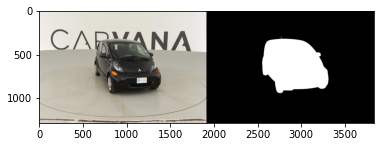

In [26]:
# Work with PIL
iu_pil = image_utils(image_type=Image.Image)
random_image_mask_pairs =pu.get_random_image_pairs('TRAIN','TRAIN_MASKS',1)
for image, mask in random_image_mask_pairs:
    iu_pil.show_image_mask_pair(image, mask)

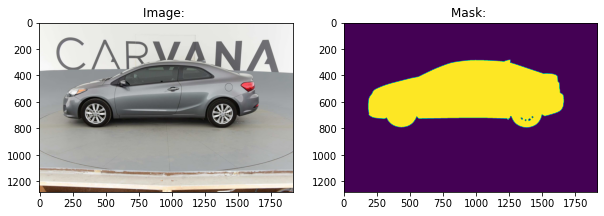

In [27]:
# Work with skimage
random_image_mask_pairs =pu.get_random_image_pairs('TRAIN','TRAIN_MASKS',1)
for image, mask in random_image_mask_pairs:
    iu.show_image_mask_pair(image, mask)

# Create Torch Dataset

Next we will create a torch.utils.data.Dataset for our segmentation problem.

Here, we should define
* `__init__()`
* `__len__()`
* `__getitem__()`

In [28]:
from torch.utils.data import Dataset, DataLoader

class SegmentationDatasetNumpy(Dataset):
    # Sample of our dataset will be a dict {'image': image, 'mask': mask}

    def __init__(self, images_path_list, masks_path_list, transform=None):
        self.images_path_list = images_path_list
        self.masks_path_list = masks_path_list
        self.transform = transform

    def __len__(self):
        return len(self.images_path_list)

    def __getitem__(self, idx):

        if torch.is_tensor(idx):
            idx = idx.tolist()

        image_path = self.images_path_list[idx]
        image = io.imread(image_path)
        # NB: To use PIL change to-> image = Image.open((image_path))
        
        if self.masks_path_list is not None:
            mask_path = self.masks_path_list[idx]
            mask = io.imread(mask_path)
            # NB: To use PIL change to-> mask = Image.open((mask_path))
        else:
            mask = None
                
        sample = {'image':  image, 'mask':  mask}

        return sample

In [29]:
from torch.utils.data import Dataset, DataLoader

class SegmentationDataset(Dataset):
    # Sample of our dataset will be a dict {'image': image, 'mask': mask}
    # This version will use PIL

    def __init__(self, images_path_list, masks_path_list, transform=None):
        self.images_path_list = images_path_list
        self.masks_path_list = masks_path_list
        self.transform = transform

    def __len__(self):
        return len(self.images_path_list)

    @classmethod
    def preprocess(cls, pil_img, scale):
        w, h = pil_img.size
        newW, newH = int(scale * w), int(scale * h)
        assert newW > 0 and newH > 0, 'Scale is too small'
        pil_img = pil_img.resize((newW, newH))

        img_nd = np.array(pil_img)

        if len(img_nd.shape) == 2:
            img_nd = np.expand_dims(img_nd, axis=2)

        # HWC to CHW
        img_trans = img_nd.transpose((2, 0, 1))
        if img_trans.max() > 1:
            img_trans = img_trans / 255

        return img_trans

    def __getitem__(self, idx):

        if torch.is_tensor(idx):
            idx = idx.tolist()

        image_path = self.images_path_list[idx]
        
        # NB: To use np.ndarray change to-> image = io.imread(image_path)
        image = Image.open((image_path))
        image = self.preprocess(image, 0.5)
        image = torch.from_numpy(image).type(torch.FloatTensor)
        
        if self.masks_path_list is not None:
            mask_path = self.masks_path_list[idx]
            
            # NB: To use PIL change to-> mask = io.imread(mask_path)
            mask = Image.open((mask_path))
            mask = self.preprocess(mask, 0.5)
            mask = torch.from_numpy(mask).type(torch.FloatTensor)

        else:
            mask = None
        
        sample = {'image': image, 'mask':  mask }

        return sample

In [30]:
seg_dataset = SegmentationDataset(pu.path_lists['TRAIN'],\
                                  pu.path_lists['TRAIN_MASKS'],\
                                  None)


In [32]:
# iu.torch_dataset_iterator(seg_dataset)

In [33]:
batch_size=4
num_workers=4

# Catalyst uses normal torch.data.DataLoader
seg_loader = DataLoader(
    seg_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)




In [34]:
from torch.utils.data import random_split, DataLoader
val_size=0.1


In [35]:
val_samples = int(len(seg_dataset)*val_size)
train_samples = len(seg_dataset) - val_samples
t, v = random_split(seg_dataset, [train_samples, val_samples])
print(len(t), train_samples, len(v), val_samples, len(seg_dataset))

4580 4580 508 508 5088


# Dataloaders

In [36]:
import pytorch_lightning as pl
from torch.utils.data import random_split, DataLoader
from torchvision import transforms

class SegmentationDataModule(pl.LightningDataModule):

    def __init__(self, train_path, masks_path, val_size=0.1, batch_size=32, num_workers=4, drop_last=True):
        super().__init__()
        self.train_path = train_path
        self.masks_path = masks_path
        # self.transform = transforms.Compose([
        #     transforms.ToTensor(),
        #     transforms.Normalize((0.1307,), (0.3081,))
        # ])
        self.transform = None

        # Size of validation set (as a percentage)
        self.val_size = val_size

        # Useful variables to have contol over at init
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.drop_last = drop_last

    def prepare_data(self):
        # download (could possibly call googledrive downloader utility here??)
        #MNIST(self.data_dir, train=True, download=True)
        #MNIST(self.data_dir, train=False, download=True)
        pass

    def setup(self, stage=None):

        # Assign train/val datasets for use in dataloaders
        if stage == 'fit' or stage is None:

            full_train_dataset = SegmentationDataset(self.train_path, self.masks_path, transform=self.transform)

            num_val_samples = int(len(full_train_dataset)*self.val_size)
            num_train_samples = len(full_train_dataset) - val_samples

            self.train_dataset, self.val_dataset = random_split(full_train_dataset, [num_train_samples, num_val_samples])

            #print(self.train_dataset[0]['image'].shape)
            self.dims = tuple(self.train_dataset[0]['image'].shape)

        # Assign test dataset for use in dataloader(s)
        if stage == 'test' or stage is None:

            self.test_dataset = SegmentationDataset(self.test_path, None, transform=self.transform)

            self.dims = getattr(self, 'dims', self.test_dataset[0]['image'].shape)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, 
                          batch_size=self.batch_size,
                          shuffle=True,
                          num_workers=self.num_workers,
                          drop_last=self.drop_last
                          )

    def val_dataloader(self):
        return DataLoader(self.val_dataset, 
                          batch_size=self.batch_size,
                          shuffle=False,
                          num_workers=self.num_workers,
                          drop_last=self.drop_last
                          )

    def test_dataloader(self):
        return DataLoader(self.test_dataset, 
                          batch_size=self.batch_size,
                          shuffle=False,
                          num_workers=self.num_workers,
                          drop_last=self.drop_last
                          )


In [37]:
seg_data_module = SegmentationDataModule(pu.path_lists['TRAIN'],\
                                  pu.path_lists['TRAIN_MASKS'])

seg_data_module.prepare_data()
seg_data_module.setup('fit')


In [38]:
# i =0 
# for batch in seg_data_module.train_dataloader():
#     print(i)
#     i=i+1

In [39]:
14*32

448

In [65]:
import os
import logging
from argparse import ArgumentParser
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch import optim
from torch.utils.data import DataLoader, random_split
from torch.utils.data.distributed import DistributedSampler

import pytorch_lightning as pl

#from dataset import DirDataset


class Unet(pl.LightningModule):
    def __init__(self):
        super(Unet, self).__init__()
        #self.hparams = hparams

        self.n_channels = 3
        self.n_classes = 1
        self.bilinear = True

        def double_conv(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
            )

        def down(in_channels, out_channels):
            return nn.Sequential(
                nn.MaxPool2d(2),
                double_conv(in_channels, out_channels)
            )

        class up(nn.Module):
            def __init__(self, in_channels, out_channels, bilinear=True):
                super().__init__()

                if bilinear:
                    self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
                else:
                    self.up = nn.ConvTranpose2d(in_channels // 2, in_channels // 2,
                                                kernel_size=2, stride=2)

                self.conv = double_conv(in_channels, out_channels)

            def forward(self, x1, x2):
                x1 = self.up(x1)
                # [?, C, H, W]
                diffY = x2.size()[2] - x1.size()[2]
                diffX = x2.size()[3] - x1.size()[3]

                x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                                diffY // 2, diffY - diffY // 2])
                x = torch.cat([x2, x1], dim=1) ## why 1?
                return self.conv(x)

        self.inc = double_conv(self.n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.out = nn.Conv2d(64, self.n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        return self.out(x)

    def training_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self.forward(x)
        loss = F.cross_entropy(y_hat, y) if self.n_classes > 1 else \
            F.binary_cross_entropy_with_logits(y_hat, y)
        tensorboard_logs = {'train_loss': loss}
        return {'loss': loss, 'log': tensorboard_logs}

    def validation_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self.forward(x)
        loss = F.cross_entropy(y_hat, y) if self.n_classes > 1 else \
            F.binary_cross_entropy_with_logits(y_hat, y)
        return {'val_loss': loss}

    def validation_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        tensorboard_logs = {'val_loss': avg_loss}
        return {'avg_val_loss': avg_loss, 'log': tensorboard_logs}

    def configure_optimizers(self):
        return torch.optim.RMSprop(self.parameters(), lr=0.1, weight_decay=1e-8)

    def __dataloader(self):
        #dataset = self.hparams.dataset
        #dataset = DirDataset(f'./dataset/{dataset}/train', f'./dataset/{dataset}/train_masks')

        dataset = SegmentationDataset(pu.path_lists['TRAIN'],\
                                  pu.path_lists['TRAIN_MASKS'],\
                                  None)

        n_val = int(len(dataset) * 0.1)
        n_train = len(dataset) - n_val
        train_ds, val_ds = random_split(dataset, [n_train, n_val])
        train_loader = DataLoader(train_ds, batch_size=1, pin_memory=True, shuffle=True)
        val_loader = DataLoader(val_ds, batch_size=1, pin_memory=True, shuffle=False)

        return {
            'train': train_loader,
            'val': val_loader,
        }

    def train_dataloader(self):
        return self.__dataloader()['train']

    def val_dataloader(self):
        return self.__dataloader()['val']

    @staticmethod
    def add_model_specific_args(parent_parser):
        parser = ArgumentParser(parents=[parent_parser])

        parser.add_argument('--n_channels', type=int, default=3)
        parser.add_argument('--n_classes', type=int, default=1)
        return parser

In [66]:
net = UNet(num_classes=1)

In [67]:
from pytorch_lightning import Trainer

In [73]:
 trainer = Trainer(gpus=1, progress_bar_refresh_rate = 20, enable_pl_optimizer=False)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [74]:
trainer.fit(net)

ModuleAttributeError: ignored

# UNET 

In the following cells, we will now try to run a Unet based on

https://github.com/milesial/Pytorch-UNet

We will make it as basic as possible

In [40]:
# dice_loss.py
import torch
from torch.autograd import Function


class DiceCoeff(Function):
    """Dice coeff for individual examples"""

    def forward(self, input, target):
        self.save_for_backward(input, target)
        eps = 0.0001
        self.inter = torch.dot(input.view(-1), target.view(-1))
        self.union = torch.sum(input) + torch.sum(target) + eps

        t = (2 * self.inter.float() + eps) / self.union.float()
        return t

    # This function has only a single output, so it gets only one gradient
    def backward(self, grad_output):

        input, target = self.saved_variables
        grad_input = grad_target = None

        if self.needs_input_grad[0]:
            grad_input = grad_output * 2 * (target * self.union - self.inter) \
                         / (self.union * self.union)
        if self.needs_input_grad[1]:
            grad_target = None

        return grad_input, grad_target


def dice_coeff(input, target):
    """Dice coeff for batches"""
    if input.is_cuda:
        s = torch.FloatTensor(1).cuda().zero_()
    else:
        s = torch.FloatTensor(1).zero_()

    for i, c in enumerate(zip(input, target)):
        s = s + DiceCoeff().forward(c[0], c[1])

    return s / (i + 1)

In [41]:
""" Parts of the U-Net model """

import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [42]:
""" Full assembly of the parts to form the complete network """

import torch.nn.functional as F


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [43]:
net = UNet(n_channels=3, n_classes=1, bilinear=True)


In [44]:
import torch.nn as nn
from torch import optim
from tqdm import tqdm

optimizer = optim.RMSprop(net.parameters(), lr=0.001, weight_decay=1e-8, momentum=0.9)

In [45]:
criterion = nn.BCEWithLogitsLoss()

In [46]:
full_train_dataset = SegmentationDataset(pu.path_lists['TRAIN'],\
                                  pu.path_lists['TRAIN_MASKS'],\
                                  None)

num_val_samples = int(len(full_train_dataset)*val_size)
num_train_samples = len(full_train_dataset) - val_samples

train_dataset, val_dataset = random_split(full_train_dataset, [num_train_samples, num_val_samples])

#print(train_dataset[0]['image'].shape)
dims = tuple(train_dataset[0]['image'].shape)

drop_last = True
num_workers = 4

train_loader = DataLoader(train_dataset, 
                batch_size=batch_size,
                shuffle=True,
                num_workers=num_workers,
                drop_last=drop_last
                )

val_loader = DataLoader(val_dataset, 
                batch_size=batch_size,
                shuffle=False,
                num_workers=num_workers,
                drop_last=drop_last
                )


In [50]:
device

device(type='cuda')

In [49]:
epochs = 1
n_val = 508
n_train = 4580 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_classes = 1

for epoch in range(epochs):
        net.train()

        epoch_loss = 0
        with tqdm(total=n_train, desc=f'Epoch {epoch + 1}/{epochs}', unit='img') as pbar:
            for batch in train_loader:
                imgs = batch['image']
                true_masks = batch['mask']
                assert imgs.shape[1] == net.n_channels, \
                    f'Network has been defined with {net.n_channels} input channels, ' \
                    f'but loaded images have {imgs.shape[1]} channels. Please check that ' \
                    'the images are loaded correctly.'

                imgs = imgs.to(device=device, dtype=torch.float32)
                #mask_type = torch.float32 if net.n_classes == 1 else torch.long
                true_masks = true_masks.to(device=device, dtype=torch.float32)

                masks_pred = net(imgs)
                loss = criterion(masks_pred, true_masks)
                epoch_loss += loss.item()
                #writer.add_scalar('Loss/train', loss.item(), global_step)

                pbar.set_postfix(**{'loss (batch)': loss.item()})

                optimizer.zero_grad()
                loss.backward()
                #nn.utils.clip_grad_value_(net.parameters(), 0.1)
                optimizer.step()

                pbar.update(imgs.shape[0])


Epoch 1/1:   0%|          | 0/4580 [00:01<?, ?img/s]


RuntimeError: ignored

In [ ]:
blah

In [ ]:
import collections
from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader

def get_loaders(
    images: List[Path],
    masks: List[Path],
    random_state: int,
    valid_size: float = 0.2,
    batch_size: int = 32,
    num_workers: int = 4,
    train_transforms_fn = None,
    valid_transforms_fn = None,
) -> dict:

    indices = np.arange(len(images))

    # Let's divide the data set into train and valid parts.
    train_indices, valid_indices = train_test_split(
      indices, test_size=valid_size, random_state=random_state, shuffle=True
    )

    np_images = np.array(images)
    np_masks = np.array(masks)

    # Creates our train dataset
    train_dataset = SegmentationDataset(
      images = np_images[train_indices].tolist(),
      masks = np_masks[train_indices].tolist(),
      transforms = train_transforms_fn
    )

    # Creates our valid dataset
    valid_dataset = SegmentationDataset(
      images = np_images[valid_indices].tolist(),
      masks = np_masks[valid_indices].tolist(),
      transforms = valid_transforms_fn
    )

    # Catalyst uses normal torch.data.DataLoader
    train_loader = DataLoader(
      train_dataset,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      drop_last=True,
    )

    valid_loader = DataLoader(
      valid_dataset,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      drop_last=True,
    )

    # And excpect to get an OrderedDict of loaders
    loaders = collections.OrderedDict()
    loaders["train"] = train_loader
    loaders["valid"] = valid_loader

    return loaders

## Requirements

Download and install the latest versions of catalyst and other libraries required for this tutorial.

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# import os
# os.chdir('/content/drive/My Drive/projects/adelaideuni')
# !pwd

In [ ]:
# # this variable will be used in `runner.train` and by default we disable FP16 mode
# is_fp16_used = False

In [ ]:
# # Catalyst
# !pip install catalyst==20.12 -qq

# # for augmentations
# !pip install albumentations==0.4.3 -qq

# # for pretrained segmentation models for PyTorch
# !pip install segmentation-models-pytorch==0.1.0 -qq

# # for TTA
# !pip install ttach==0.0.2 -qq

# # for tensorboard
# !pip install tensorflow -qq

# # if Your machine support Apex FP16, uncomment this 3 lines below
# # !git clone https://github.com/NVIDIA/apex
# # !pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./apex
# # is_fp16_used = True

## Setting up GPUs

In [ ]:
from typing import Callable, List, Tuple

import os
import torch
import catalyst
from catalyst import utils

print(f"torch: {torch.__version__}, catalyst: {catalyst.__version__}")

# os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # "" - CPU, "0" - 1 GPU, "0,1" - MultiGPU

SEED = 42
utils.set_global_seed(SEED)
utils.prepare_cudnn(deterministic=True)

## Dataset

As a dataset we will take Carvana - binary segmentation for the "car" class.

> If you are on MacOS and you don’t have `wget`, you can install it with: `brew install wget`.

After Catalyst installation, `download-gdrive` function become available to download objects from Google Drive.
We use it to download datasets.

usage: `download-gdrive {FILE_ID} {FILENAME}`

In [ ]:
from pathlib import Path

ROOT = Path("segmentation_data/")

train_image_path = ROOT / "train"
train_mask_path = ROOT / "train_masks"
test_image_path = ROOT / "test"

Collect images and masks into variables.

In [ ]:
ALL_IMAGES = sorted(train_image_path.glob("*.jpg"))
len(ALL_IMAGES)

In [ ]:
ALL_MASKS = sorted(train_mask_path.glob("*.gif"))
len(ALL_MASKS)

In [ ]:
import random

In [ ]:
import random
def get_random_subset(list_in: List[Path], sample_size):
    return [ALL_IMAGES[random.randint(0, len(list_in) - 1)] for x in range(10)]

test_limit = 32*10
ALL_IMAGES_TEST = get_random_subset(ALL_IMAGES, test_limit)
ALL_MASKS_TEST = get_random_subset(ALL_MASKS, test_limit)

print(f'Train dataset has {len(ALL_IMAGES)} images')
print(f'Mask dataset has {len(ALL_MASKS)} masks')

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread as gif_imread
from catalyst import utils


def show_examples(name: str, image: np.ndarray, mask: np.ndarray):
    plt.figure(figsize=(10, 14))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"Image: {name}")

    plt.subplot(1, 2, 2)
    plt.imshow(mask)
    plt.title(f"Mask: {name}")


def show(index: int, images: List[Path], masks: List[Path], transforms=None) -> None:
    image_path = images[index]
    name = image_path.name

    image = utils.imread(image_path)
    mask = gif_imread(masks[index])

    if transforms is not None:
        temp = transforms(image=image, mask=mask)
        image = temp["image"]
        mask = temp["mask"]

    show_examples(name, image, mask)

def show_random(images: List[Path], masks: List[Path], transforms=None) -> None:
    length = len(images)
    index = random.randint(0, length - 1)
    show(index, images, masks, transforms)

You can restart the cell below to see more examples.

In [ ]:
show_random(ALL_IMAGES, ALL_MASKS)

The dataset below reads images and masks and optionally applies augmentation to them.

In [ ]:
from typing import List

from torch.utils.data import Dataset


class SegmentationDataset(Dataset):
    def __init__(
        self,
        images: List[Path],
        masks: List[Path] = None,
        transforms=None
    ) -> None:
        self.images = images
        self.masks = masks
        self.transforms = transforms

    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, idx: int) -> dict:
        image_path = self.images[idx]
        image = utils.imread(image_path)
        
        result = {"image": image}
        
        if self.masks is not None:
            mask = gif_imread(self.masks[idx])
            result["mask"] = mask
        
        if self.transforms is not None:
            result = self.transforms(**result)
        
        result["filename"] = image_path.name

        return result

-------

### Augmentations

[![Albumentation logo](https://albumentations.readthedocs.io/en/latest/_static/logo.png)](https://github.com/albu/albumentations)

The [albumentation](https://github.com/albu/albumentations) library works with images and masks at the same time, which is what we need.

In [ ]:
import albumentations as albu
from albumentations.pytorch import ToTensor


def pre_transforms(image_size=224):
    return [albu.Resize(image_size, image_size, p=1)]


def hard_transforms():
    result = [
      albu.RandomRotate90(),
      albu.Cutout(),
      albu.RandomBrightnessContrast(
          brightness_limit=0.2, contrast_limit=0.2, p=0.3
      ),
      albu.GridDistortion(p=0.3),
      albu.HueSaturationValue(p=0.3)
    ]

    return result
  

def resize_transforms(image_size=224):
    BORDER_CONSTANT = 0
    pre_size = int(image_size * 1.5)

    random_crop = albu.Compose([
      albu.SmallestMaxSize(pre_size, p=1),
      albu.RandomCrop(
          image_size, image_size, p=1
      )

    ])

    rescale = albu.Compose([albu.Resize(image_size, image_size, p=1)])

    random_crop_big = albu.Compose([
      albu.LongestMaxSize(pre_size, p=1),
      albu.RandomCrop(
          image_size, image_size, p=1
      )

    ])

    # Converts the image to a square of size image_size x image_size
    result = [
      albu.OneOf([
          random_crop,
          rescale,
          random_crop_big
      ], p=1)
    ]

    return result
  
def post_transforms():
    # we use ImageNet image normalization
    # and convert it to torch.Tensor
    return [albu.Normalize(), ToTensor()]
  
def compose(transforms_to_compose):
    # combine all augmentations into single pipeline
    result = albu.Compose([
      item for sublist in transforms_to_compose for item in sublist
    ])
    return result

In [ ]:
train_transforms = compose([
    resize_transforms(), 
    hard_transforms(), 
    post_transforms()
])
valid_transforms = compose([pre_transforms(), post_transforms()])

show_transforms = compose([resize_transforms(), hard_transforms()])

Let's look at the augmented results. <br/>
You can restart the cell below to see more examples of augmentations.

In [ ]:
show_random(ALL_IMAGES, ALL_MASKS, transforms=show_transforms)

-------

## Loaders

In [ ]:
import collections
from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader

def get_loaders(
    images: List[Path],
    masks: List[Path],
    random_state: int,
    valid_size: float = 0.2,
    batch_size: int = 32,
    num_workers: int = 4,
    train_transforms_fn = None,
    valid_transforms_fn = None,
) -> dict:

    indices = np.arange(len(images))

    # Let's divide the data set into train and valid parts.
    train_indices, valid_indices = train_test_split(
      indices, test_size=valid_size, random_state=random_state, shuffle=True
    )

    np_images = np.array(images)
    np_masks = np.array(masks)

    # Creates our train dataset
    train_dataset = SegmentationDataset(
      images = np_images[train_indices].tolist(),
      masks = np_masks[train_indices].tolist(),
      transforms = train_transforms_fn
    )

    # Creates our valid dataset
    valid_dataset = SegmentationDataset(
      images = np_images[valid_indices].tolist(),
      masks = np_masks[valid_indices].tolist(),
      transforms = valid_transforms_fn
    )

    # Catalyst uses normal torch.data.DataLoader
    train_loader = DataLoader(
      train_dataset,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      drop_last=True,
    )

    valid_loader = DataLoader(
      valid_dataset,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      drop_last=True,
    )

    # And excpect to get an OrderedDict of loaders
    loaders = collections.OrderedDict()
    loaders["train"] = train_loader
    loaders["valid"] = valid_loader

    return loaders

In [ ]:
if is_fp16_used:
    batch_size = 64
else:
    batch_size = 32

print(f"batch_size: {batch_size}")

loaders = get_loaders(
    images=ALL_IMAGES,
    masks=ALL_MASKS,
    random_state=SEED,
    train_transforms_fn=train_transforms,
    valid_transforms_fn=valid_transforms,
    batch_size=batch_size
)

-------

## Experiment
### Model

Catalyst has [several segmentation models](https://github.com/catalyst-team/catalyst/blob/master/catalyst/contrib/models/segmentation/__init__.py#L16) (Unet, Linknet, FPN, PSPnet and their versions with pretrain from Resnet).

> You can read more about them in [our blog post](https://github.com/catalyst-team/catalyst-info#catalyst-info-1-segmentation-models).

But for now let's take the model from [segmentation_models.pytorch](https://github.com/qubvel/segmentation_models.pytorch) (SMP for short). The same segmentation architectures have been implemented in this repository, but there are many more pre-trained encoders.

[![Segmentation Models logo](https://raw.githubusercontent.com/qubvel/segmentation_models.pytorch/master/pics/logo-small-w300.png)](https://github.com/qubvel/segmentation_models.pytorch)

In [ ]:
import segmentation_models_pytorch as smp

# We will use Feature Pyramid Network with pre-trained ResNeXt50 backbone
model = smp.FPN(encoder_name="resnext50_32x4d", classes=1)

### Model training

We will optimize loss as the sum of IoU, Dice and BCE, specifically this function: $IoU + Dice + 0.8*BCE$.


In [ ]:
from torch import nn

from catalyst.contrib.nn import DiceLoss, IoULoss

# we have multiple criterions
criterion = {
    "dice": DiceLoss(),
    "iou": IoULoss(),
    "bce": nn.BCEWithLogitsLoss()
}

In [ ]:
from torch import optim

from catalyst.contrib.nn import RAdam, Lookahead

learning_rate = 0.001
encoder_learning_rate = 0.0005

# Since we use a pre-trained encoder, we will reduce the learning rate on it.
layerwise_params = {"encoder*": dict(lr=encoder_learning_rate, weight_decay=0.00003)}

# This function removes weight_decay for biases and applies our layerwise_params
model_params = utils.process_model_params(model, layerwise_params=layerwise_params)

# Catalyst has new SOTA optimizers out of box
base_optimizer = RAdam(model_params, lr=learning_rate, weight_decay=0.0003)
optimizer = Lookahead(base_optimizer)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.25, patience=2)

In [ ]:
from catalyst.dl import SupervisedRunner

num_epochs = 3
logdir = "./logs/segmentation"

device = utils.get_device()
print(f"device: {device}")

if is_fp16_used:
    fp16_params = dict(opt_level="O1") # params for FP16
else:
    fp16_params = None

print(f"FP16 params: {fp16_params}")


# by default SupervisedRunner uses "features" and "targets",
# in our case we get "image" and "mask" keys in dataset __getitem__
runner = SupervisedRunner(device=device, input_key="image", input_target_key="mask")

### Monitoring in tensorboard

If you do not have a Tensorboard opened after you have run the cell below, try running the cell again.

In [ ]:
%load_ext tensorboard
%tensorboard --logdir {logdir}

### Running train-loop

In [ ]:
from catalyst.dl import DiceCallback, IouCallback, \
  CriterionCallback, MetricAggregationCallback
from catalyst.contrib.callbacks import DrawMasksCallback

callbacks = [
    # Each criterion is calculated separately.
    CriterionCallback(
        input_key="mask",
        prefix="loss_dice",
        criterion_key="dice"
    ),
    CriterionCallback(
        input_key="mask",
        prefix="loss_iou",
        criterion_key="iou"
    ),
    CriterionCallback(
        input_key="mask",
        prefix="loss_bce",
        criterion_key="bce"
    ),

    # And only then we aggregate everything into one loss.
    MetricAggregationCallback(
        prefix="loss",
        mode="weighted_sum", # can be "sum", "weighted_sum" or "mean"
        # because we want weighted sum, we need to add scale for each loss
        metrics={"loss_dice": 1.0, "loss_iou": 1.0, "loss_bce": 0.8},
    ),

    # metrics
    DiceCallback(input_key="mask"),
    IouCallback(input_key="mask"),
    # visualization
    DrawMasksCallback(output_key='logits',
                      input_image_key='image',
                      input_mask_key='mask',
                      summary_step=50
    )
]

runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    # our dataloaders
    loaders=loaders,
    # We can specify the callbacks list for the experiment;
    callbacks=callbacks,
    # path to save logs
    logdir=logdir,
    num_epochs=num_epochs,
    # save our best checkpoint by IoU metric
    main_metric="iou",
    # IoU needs to be maximized.
    minimize_metric=False,
    # for FP16. It uses the variable from the very first cell
    fp16=fp16_params,
    # prints train logs
    verbose=True,
)

## Model inference

Let's look at the model's predictions.


In [ ]:
TEST_IMAGES = sorted(test_image_path.glob("*.jpg"))

# create test dataset
test_dataset = SegmentationDataset(
    TEST_IMAGES, 
    transforms=valid_transforms
)

num_workers: int = 4

infer_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers
)

# this get predictions for the whole loader
predictions = np.vstack(list(map(
    lambda x: x["logits"].cpu().numpy(), 
    runner.predict_loader(loader=infer_loader, resume=f"{logdir}/checkpoints/best.pth")
)))

print(type(predictions))
print(predictions.shape)

In [ ]:
threshold = 0.5
max_count = 5

for i, (features, logits) in enumerate(zip(test_dataset, predictions)):
    image = utils.tensor_to_ndimage(features["image"])

    mask_ = torch.from_numpy(logits[0]).sigmoid()
    mask = utils.detach(mask_ > threshold).astype("float")
        
    show_examples(name="", image=image, mask=mask)
    
    if i >= max_count:
        break

In [ ]:
## Model tracing

Catalyst allows you to use Runner to make [tracing](https://pytorch.org/docs/stable/jit.html) models.

> How to do this in the Config API, we wrote in [our blog (issue \#2)](https://github.com/catalyst-team/catalyst-info#catalyst-info-2-tracing-with-torchjit)

For this purpose it is necessary to pass in a method `trace ` model and a batch on which `predict_batch ` will be executed:

In [ ]:
batch = next(iter(loaders["valid"]))
# saves to `logdir` and returns a `ScriptModule` class
runner.trace(model=model, batch=batch, logdir=logdir, fp16=is_fp16_used)

!ls {logdir}/trace/

After this, you can easily load the model and predict anything!

In [ ]:
from catalyst.utils import trace

if is_fp16_used:
    model = trace.load_traced_model(
        f"{logdir}/trace/traced-forward-opt_O1.pth", 
        device="cuda", 
        opt_level="O1"
    )
else:
    model = trace.load_traced_model(
        f"{logdir}/trace/traced-forward.pth", 
        device="cpu"
    )

In [ ]:
model_input = batch["image"].to("cuda" if is_fp16_used else "cpu")
model(model_input)

### Advanced: Custom Callbacks

Let's plot the heatmap of predicted masks.

In [ ]:
import collections

from catalyst.dl import Callback, CallbackOrder, IRunner


class CustomInferCallback(Callback):
    def __init__(self):
        super().__init__(CallbackOrder.Internal)
        self.heatmap = None
        self.counter = 0

    def on_loader_start(self, runner: IRunner):
        self.predictions = None
        self.counter = 0

    def on_batch_end(self, runner: IRunner):
        # data from the Dataloader
        # image, mask = runner.input["image"], runner.input["mask"]
        logits = runner.output["logits"]
        probabilities = torch.sigmoid(logits)

        self.heatmap = (
            probabilities 
            if self.heatmap is None 
            else self.heatmap + probabilities
        )
        self.counter += len(probabilities)

    def on_loader_end(self, runner: IRunner):
        self.heatmap = self.heatmap.sum(axis=0)
        self.heatmap /= self.counter

In [ ]:
from collections import OrderedDict
from catalyst.dl import CheckpointCallback


infer_loaders = {"infer": loaders["valid"]}
model = smp.FPN(encoder_name="resnext50_32x4d", classes=1)

device = utils.get_device()
if is_fp16_used:
    fp16_params = dict(opt_level="O1") # params for FP16
else:
    fp16_params = None

runner = SupervisedRunner(device=device, input_key="image", input_target_key="mask")
runner.infer(
    model=model,
    loaders=infer_loaders,
    callbacks=OrderedDict([
        ("loader", CheckpointCallback(resume=f"{logdir}/checkpoints/best.pth")),
        ("infer", CustomInferCallback())
    ]),
    fp16=fp16_params,
)

In [ ]:
import matplotlib
%matplotlib inline 
import matplotlib.pyplot as plt

heatmap = utils.detach(runner.runner.callbacks["infer"].heatmap[0])
plt.figure(figsize=(20, 9))
plt.imshow(heatmap, cmap="hot", interpolation="nearest")
plt.show()

### Advanced: test-time augmentations (TTA)

There is [ttach](https://github.com/qubvel/ttach) is a new awesome library for test-time augmentation for segmentation or classification tasks.

In [ ]:
import ttach as tta

# D4 makes horizontal and vertical flips + rotations for [0, 90, 180, 270] angels.
# and then merges the result masks with merge_mode="mean"
tta_model = tta.SegmentationTTAWrapper(model, tta.aliases.d4_transform(), merge_mode="mean")

tta_runner = SupervisedRunner(
    model=tta_model,
    device=utils.get_device(),
    input_key="image"
)

In [ ]:
infer_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=num_workers
)

batch = next(iter(infer_loader))

# predict_batch will automatically move the batch to the Runner's device
tta_predictions = tta_runner.predict_batch(batch)

# shape is `batch_size x channels x height x width`
print(tta_predictions["logits"].shape)

Let's see our mask after TTA

In [ ]:
threshold = 0.5

image = utils.tensor_to_ndimage(batch["image"][0])

mask_ = tta_predictions["logits"][0, 0].sigmoid()
mask = utils.detach(mask_ > threshold).astype("float")

show_examples(name="", image=image, mask=mask)